# [A3] Principal Component Analysis (PCA)

In this exercise, the concept of **dimensionality reduction** is introduced by implementing a principal componant analysis (PCA) step-by-step using eigendecomposition, calculating characteristic polynomials, eigenvalues and -vectors and of course principal components.

## 1: What is PCA?
The goal of PCA is to identify patterns in data by exploring the correlation between variables. If variables are strongly correlated, the dimensionality of a problem can be reduced using PCA: in simple terms, two or more features of a dataset can be combined into a fewer number of features that are calculated using the PCA. 

The idea is to identify the directions with maximum variance (eigenvectors) in high $d$-dimensional data and project the data to a smaller ($k$)-dimensional subspace ($k < d$) while retaining most of the information.

A summary of the PCA approach:
1. Determining eigenvectors and eigenvalues using covariance matrix. 
2. Sorting eigenvalues in descending order and selecting $k$ eigenvectors corresponding to the $k$ largest eigenvalues.
3. Constructing a projection matrix $W$ from the selected $k$ eigenvectors.
4. Transforming the original data set X over W to obtain a $k$-dimensional feature subspace $Y$.


## 2: Applying PCA to the IRIS dataset
To provide a practical understanding of PCA, the concept is implemented below using the IRIS dataset (which was introduced in the first exercise).

### 2.1: Preprocessing: Import & Visualization
As usual, we start by importing and then splitting the data into features ($X$) and labels ($y$).

In [45]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from seaborn import scatterplot
from sklearn.decomposition import PCA


iris_data_raw = pd.read_csv(
    "data/iris.data",
    header=None,
    sep=",",
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"],
)

# split data table into data X and class labels y
iris_X = iris_data_raw.iloc[:, 0:4].values
iris_y = iris_data_raw.iloc[:, 4].values

display(iris_data_raw.head(2), iris_X.shape, iris_X[0:3])

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


(150, 4)

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

The distribution of the feature values for each of the 3 different flower classes can be visualized via histograms:

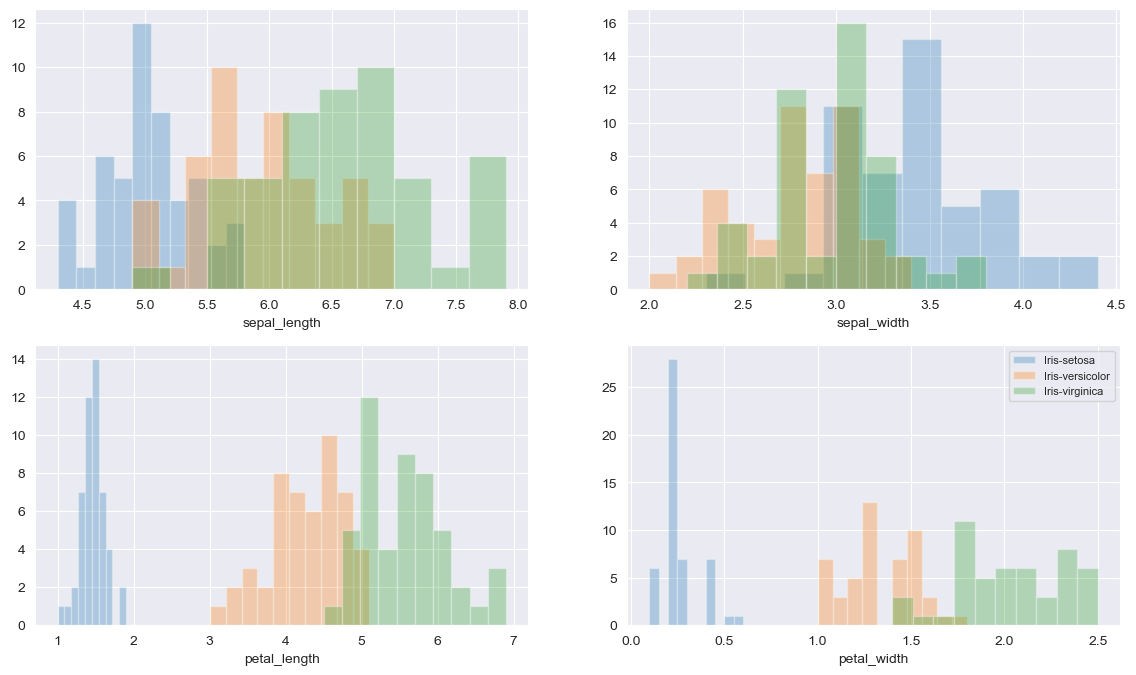

In [46]:
plt.figure(figsize=(14, 8))
for colid, colname in enumerate(iris_data_raw.columns[:-1]):
    plt.subplot(2, 2, colid + 1)
    for lab in iris_data_raw["class"].unique():
        plt.hist(
            iris_X[iris_y == lab, colid],
            label=lab,
            bins=10,
            alpha=0.3,
        )
    plt.xlabel(colname)
plt.legend(loc="upper right", fancybox=True, fontsize=8)

plt.show()

### 2.2: ✏️ Calculation of the covariance matrix $C$
The "core" principle of PCA is to retreive eigenvectors and eigenvalues of the covariance matrix $C \in I\!R^{d \times d}$ of the dataset $ g $ using an eigendecomposition.

Each element $ \sigma_{jk} \in C $ represents the covariance between two features. 


<!-- $\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{n}\left( x_{ij}-\bar{x}_j \right) \left( x_{ik}-\bar{x}_k \right).$ -->

The calculation of the covariance matrix is summarized by the following matrix equation:

$C = \frac{1}{N-1} G G^T $ 
with the centered dataset $ G = (g^T - g_{mean})^T \in  \mathbb{R}^{d \times N}$ 
and the mean vector $g_{mean} = \left( \frac{1}{N} \sum\limits_{n=1}^N g_{n} \right) \in \mathbb{R}^d$ containing the mean for each feature of the dataset.

✏️ Implement the covariance matrix on your own (using numpy methods). Verify the result of your implementation using the ``numpy.cov()`` function.
Note that numpy requires you to transpose your DataFrame values first, as it expects each object to be represented as a column.

In [47]:
def covariance_matrix(g):
    mean = np.mean(g.T, axis=0,keepdims=True) # why do I need to g.T? axis=0? Should it not be (g.T - g).T?
    G = (g.T - mean).T #TODO ask tutor about this
    return G@G.T*(1/(g.shape[1]-1))

cov_mat = covariance_matrix(iris_X.T) # why .T here?

print("Covariance matrix: ", cov_mat)
print("NumPy covariance matrix: ", np.cov(iris_X.T))

Covariance matrix:  [[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]
NumPy covariance matrix:  [[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]


T### 2.3: Eigendecomposition - Calculation of eigenvectors and eigenvalues
Given the covariance matrix, we can now perform an eigendecomposition of it, providing both

- the eigenvectors (principal components) that determine the directions of the new feature space and
- the eigenvalues that determine the magnitude/size (they explain the variance of the data along the new feature axes).

#### 2.3.1: ✏️ Characteristic Polynomial and Eigenvalues

The **eigenvalues** are defined as the zero points of the **characteristic polynomial**. 

1. Calculate the characteristic polynomial:

In [48]:
# TODO ask Tutor if Faddeev–LeVerrier algorithm was the intended way
def calculate_characteristic_polynomial(g):
    # define M_0
    A = g
    n = len(g)
    M_0 = np.zeros((n,n))
    I = np.eye(n)
    M = {
        0: M_0,
    }

    # define c_n
    C = {
        n: 1,
    }


    for k in range(1, n+1):
        #print(f"{k=}, A@Mk {A@M[k-1]}, Cn {C[n-(k-1)]}")
        M_k = A@M[k-1] + C[n-(k-1)]*I
        M[k] = M_k
        c_nk = -(1/k)*np.trace(A@M[k])
        C[n-k] = c_nk

    return list(C.values()) #is this sorted correctly?

print("Charakteristisches Polynom:", calculate_characteristic_polynomial(cov_mat))

Charakteristisches Polynom: [1, -4.569291275167785, 1.4818672008768363, -0.11291008323404131, 0.0019032757967365555]


2. Calculate the eigenvalues $ \lambda_i $:

In [49]:
# TODO: Implement
# Find the eigenvalues by solving det(A - λI) = 0
def calculate_eigenvalues(g):
    coeffs = calculate_characteristic_polynomial(g)
    return np.roots(coeffs)

print("Eigenvalues:", calculate_eigenvalues(cov_mat))

Eigenvalues: [4.22484077 0.24224357 0.07852391 0.02368303]


#### 2.3.2: Eigenvectors Explanation
**Eigenvectors** $ \vec{e}_i $ are retrieved by solving the following linear equation (with the identity matrix $I$): 

$$ C-\lambda_i \cdot I \cdot \vec{e}_i = \vec{0} $$


In the lecture and in the exam (if this task is given), the linear equation system (_LGS_) is solved by hand at this point. 

Unfortunately, however, the common linear algebra solvers, such as numpys ``linalg.solve()``, generate only the trivial solution (you are welcome to try it out).

We herefore deviate from the lecture script and perform a [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition):

For each eigenvalue $ \lambda_i $:

1. Calculate the matrix $ m_i = (C - \lambda_i \cdot I) $ and perform a QR decomposition of $m_i^T$ using numpy, returning the matrices $q_i$ and $r_i$.

2. Determine the rank $rank(m_i)$ of the matrix as follows: 
      1. Get the index of the row in $r_i$ where all values are $0$ or "close to it" 
      2. Rank = that index (when starting index at 0)
      3. Example:  $ rank(m_i) = 3 $

         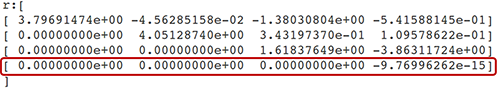

3. Determine the eigenvector(s) $ \vec{e}_i $ as follows:
      1. The eigenvectors are contained in the last $ |q_i| - rank(m_i) $ columns of $ q_i $.
      2. Example: given $ rank(m_i) = 3 $, the first $ 4 - 3 = 1 $ columns from the end are the eigenvectors (=the fourth column considered from the beginning)

         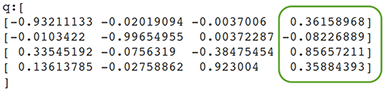


#### 2.3.3: ✏️ Eigenvectors Implementation

1. Implement the above method to calculate the eigenvectors and verify the result of your implementation using numpys ``linalg.eig()`` function.

In [50]:
import sys

def array_near_zero(arr):
    epsilon = sys.float_info.epsilon*100
    for idx, val in enumerate(arr):
        if abs(val) > epsilon:
            return False
    return True

def get_rank(m):
    for i,row in enumerate(m):
        if array_near_zero(row):
            return i
    return len(m)-1

def calculate_eigenvectors(C):
    # calculate mi = (C - li * I) then np.linalg.qr()
    eigenvals = calculate_eigenvalues(C)
    I = np.eye(len(C))
    eigenvecs = []
    for li in eigenvals:
        mi = C - li * I
        qi, ri = np.linalg.qr(mi.T)
        rank = get_rank(ri)
        # determine e
        eig_col = abs(len(qi.T)) - rank
        #print(f"Rank {rank}, qi shape {qi.shape}, column index of eigenvectors: {eig_col}")
        for ind, val2 in enumerate(qi.T[::-1]):
            if ind == eig_col-1:
                eigenvecs.append(val2)
    return np.array(eigenvecs)

eig_vals = calculate_eigenvalues(cov_mat)
eig_vecs = calculate_eigenvectors(cov_mat)

# TODO: Implement
print("Eigenvalues:", eig_vals)
print("Eigenvectors:", eig_vecs)

np_eigenvalues, np_eigenvectors = np.linalg.eig(cov_mat)
print("Eigenvalues: ", np_eigenvalues)
print("Eigenvectors: ", np_eigenvectors)

Eigenvalues: [4.22484077 0.24224357 0.07852391 0.02368303]
Eigenvectors: [[ 0.36158968 -0.08226889  0.85657211  0.35884393]
 [-0.65653988 -0.72971237  0.1757674   0.07470647]
 [-0.58099728  0.59641809  0.07252408  0.54906091]
 [ 0.31725455 -0.32409435 -0.47971899  0.75112056]]
Eigenvalues:  [4.22484077 0.24224357 0.07852391 0.02368303]
Eigenvectors:  [[ 0.36158968 -0.65653988 -0.58099728  0.31725455]
 [-0.08226889 -0.72971237  0.59641809 -0.32409435]
 [ 0.85657211  0.1757674   0.07252408 -0.47971899]
 [ 0.35884393  0.07470647  0.54906091  0.75112056]]


### 2.4: Selecting Principal Components
As mentioned, the goal of the PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace.

In this subspace, the eigenvectors form the _axes_ of the coordinate system, or more precisely, their directions - as all eigenvectors have the same unit length of 1: 

In [51]:
for ev in eig_vecs.T:
    print (ev)
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print("Ok Ok!")


[ 0.36158968 -0.65653988 -0.58099728  0.31725455]
[-0.08226889 -0.72971237  0.59641809 -0.32409435]
[ 0.85657211  0.1757674   0.07252408 -0.47971899]
[0.35884393 0.07470647 0.54906091 0.75112056]
Ok Ok!


To reduce the number of dimensions (and _axes_) we need to reduce the number of eigenvectors.

To decide which eigenvector(s) can be dropped without losing too much information, the corresponding eigenvalues must be examined: 

The eigenvectors with the lowest eigenvalues contain the least information about the distribution of the data and can be dropped.


#### 2.4.1: ✏️ Sorting the eigenpairs
1. Generate a list of tuples containing the eigenvalues and eigenvectors. Sort them based on eigenvalues from highest to lowest:

In [52]:
# TODO: Implement
def sort_eigenvalues(eig_vals):
    return sorted(eig_vals, reverse=True)


print("Eigenvalues (in descending order) and their eigenvectors:")
sorted_eig_vals = sort_eigenvalues(np_eigenvalues)
for values in sorted_eig_vals:
    print(values, " ", np_eigenvectors[sorted_eig_vals.index(values)])


Eigenvalues (in descending order) and their eigenvectors:
4.224840768320108   [ 0.36158968 -0.65653988 -0.58099728  0.31725455]
0.242243571627515   [-0.08226889 -0.72971237  0.59641809 -0.32409435]
0.07852390809415477   [ 0.85657211  0.1757674   0.07252408 -0.47971899]
0.02368302712600192   [0.35884393 0.07470647 0.54906091 0.75112056]


#### 2.4.2: ✏️ Determining the best number of Principal Components (Explained Variance)
After sorting the eigenpairs, you may ask yourself how many principal components you should keep for the new feature subspace.
A useful measure is the so-called **explained variance**, which can be calculated from the eigenvalues, indicating how much information (variance) can be assigned to each principal component.

1. Determine the explained variance by calculating the percentage of each eigenvalue in the total sum of eigenvalues:

In [53]:
# TODO: Implement
def calculate_explained_variance(eig_vals):
    var_exp = []
    sum_eig_vals = sum(eig_vals)
    for val in eig_vals:
        val /= sum_eig_vals
        var_exp.append(val)
    return var_exp

print("Eigenvalues:", np_eigenvalues)
print("Explained Variance:", calculate_explained_variance(np_eigenvalues))


Eigenvalues: [4.22484077 0.24224357 0.07852391 0.02368303]
Explained Variance: [0.9246162071742681, 0.05301556785053498, 0.01718513952500685, 0.005183085450189931]


These results show that most (92.46%) of the variance can be explained by the first principal component alone. 

The second principal component still contains some information (5.30%), while the third and fourth principal components can be safely dropped without losing too much information. 

--> Together, the first two principal components contain 97.76% of the information ==> $k=2$

### 2.5: ✏️ Creating the Projection Matrix $W$
We can now construct the projection matrix used to transform the Iris data into the new ($k=2$, two-dimensional) feature subspace.

The projection matrix $W \in I\!R^{d\times k}$ contains the top-$k$ eigenvectors as columns (and is sometimes called _eigenvector matrix_).

1. Generate the projection matrix $W$ for $k=2$ from the sorted eigenpairs.

In [54]:
k = 2
# TODO: Implement
def get_eigenvector_matrix(eig_vecs, k):
    mat = []
    for vec in eig_vecs:
        row_vec = []
        for i in range(k):
            row_vec.append(vec[i])
        mat.append(row_vec)
    return np.array(mat)

mat_W = get_eigenvector_matrix(np_eigenvectors, k)
print("Matrix W of shape", mat_W.shape)
print(mat_W)


Matrix W of shape (4, 2)
[[ 0.36158968 -0.65653988]
 [-0.08226889 -0.72971237]
 [ 0.85657211  0.1757674 ]
 [ 0.35884393  0.07470647]]


### 2.6: ✏️ Projecting the data into the new feature subspace

In this final step, the $4 \times 2$-dimensional projection matrix W is used to transform the data $X$ to the new subspace.

Mathematically, this is a simple dot product: $\hat{X}=X \cdot W$ 

1. Use the projection matrix $W$ to transform the iris dataset (``iris_X``) to fewer dimensions and output the shape of the transformed dataset.

In [55]:
# TODO: Implement
iris_X_transformed = np.dot(iris_X, mat_W)
print(iris_X_transformed.shape)

(150, 2)


### 2.7: Visualizing the projection
We have now reduced the four-dimensional feature space of the Iris dataset to two dimensions.

We can visualize these two dimensions using the following plot:

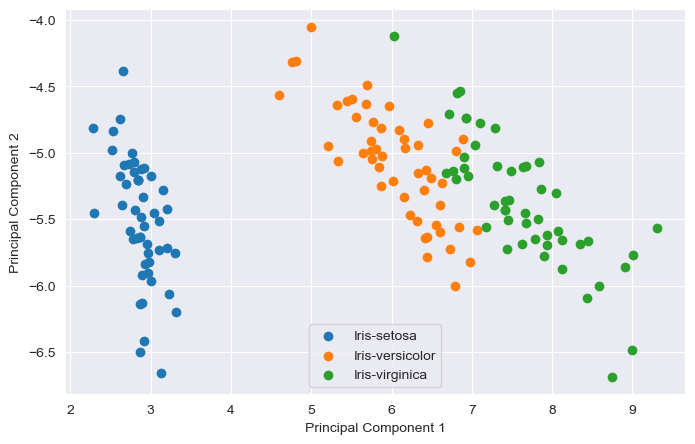

In [56]:
plt.figure(figsize=(8, 5))
for id, classname in enumerate(iris_data_raw["class"].unique()):
    plt.scatter(
        iris_X_transformed[iris_y == classname, 0],
        iris_X_transformed[iris_y == classname, 1],
        label=classname,
        c=f"C{id}",
    )
plt.gca().update(dict(xlabel="Principal Component 1", ylabel="Principal Component 2"))
plt.legend(loc="lower center")
plt.show()


Ideally, for the three classes of flowers you should see three distinct (or at least well separable) clusters. 

## 3: Applying PCA to the Fashion MNIST dataset
As a tribute to the popular MNIST image dataset of handwritten digits, fashion retail company Zalando created a dataset of similar shape and size showing images of clothing instead.

Each of the 70.000 grayscale images has 28x28 pixels.

We can apply the same techniques learned above to reduce the datasets complexity and visualize clusters in a lower dimension.

### 3.1: Import and Visualization
The data for this exercise is given in a CSV form. In practice, many image datasets will instead be provided using .png files.

,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
Id,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


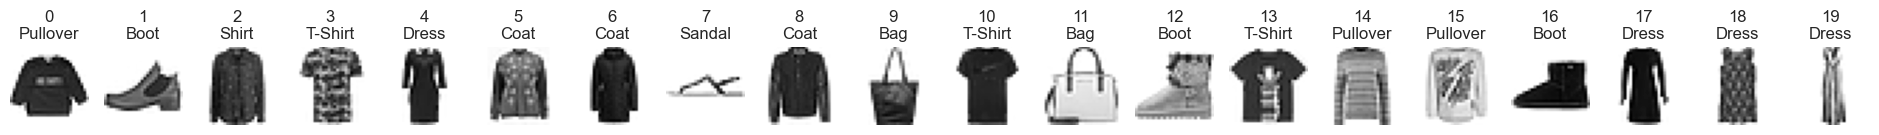

In [57]:
# Load Dataset
fm = pd.read_csv("data/fashion_mnist_train.csv.zip", index_col="Id")
fm_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]
display(fm.head(2))

# Visualize Examples
num_samples = 20
ax = plt.subplots(nrows=1, ncols=num_samples, figsize=(24, 4))[1]
for i in range(num_samples):
    ax[i].set_axis_off()
    ax[i].set_title(f"{i}\n{fm_labels[fm.Category[i]]}")
    ax[i].imshow(fm.loc[i].values[1:].reshape((28,28)), cmap="gray_r")
plt.show()

## 3.2: ✏️ Fashion MNIST Exploration
1. Take a close look at how the dataframe is structured. What do the pixel values mean? How can you use this structure to re-create an image? 

In [58]:
# TODO: Answer
# the pixel values are the greyscale values of the image
# to recreate the image you could structure the data by the image size and fill the pixels with the according grey values

2. What is the meaning of "gray_r" in the imshow function? Why is it needed when visualizing the original data?

In [59]:
# TODO: Answer
# gray_r is the greyscale value

## 3.3: ✏️ Apply PCA
1. Create separate numpy arrays for labels (``fm_y``, one-dimensional) and flattened pixels (``fm_X``, 2-dimensional).

In [60]:
# TODO: Implement
fm_y = fm["Category"]
fm_X = fm.drop(columns=["Category"])

2. Apply the [PCA method from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to the Fashion-MNIST dataset. Print the percentage of variance explained by the first 5 principal components.

In [61]:
# TODO: Implement
pca = PCA(n_components=5)
pca.fit(fm)
pca.explained_variance_

array([1284698.88376276,  785030.74235141,  266701.0730428 ,
        220096.4847407 ,  170013.89943253])

3. Use the same method to reduce the dimensionality of the dataset to 2 dimensions. Print the values of the first entry.

In [70]:
# TODO: Implement
pca = PCA(n_components=2)
pca.fit(fm)
pca.components_[1]

array([ 2.18578754e-03, -5.16670100e-08,  2.93142766e-06,  7.86140608e-06,
        4.34809425e-05,  9.86074685e-05,  1.51171248e-04,  1.16454669e-04,
       -1.46162070e-04, -1.53391569e-03, -8.44236213e-03, -2.73594072e-02,
       -3.29990209e-02, -2.74441849e-02, -2.30878723e-02, -2.06407698e-02,
       -2.38541191e-02, -2.78328660e-02, -3.02978466e-02, -2.19258352e-02,
       -4.91940815e-03, -3.03781633e-04,  4.52273649e-04,  5.01664917e-04,
        4.62463743e-04,  3.80944224e-04,  2.29719450e-04,  9.37000181e-05,
        2.18547965e-05,  7.04454793e-06,  2.24952941e-05,  5.13888281e-05,
        2.61767191e-04,  4.75667990e-04,  5.12441789e-04,  1.77654287e-04,
       -1.00749019e-03, -7.28760367e-03, -2.37993364e-02, -4.95076736e-02,
       -5.34344696e-02, -5.33869566e-02, -5.26114791e-02, -5.12415739e-02,
       -5.18808130e-02, -4.96940653e-02, -4.74308485e-02, -4.10535491e-02,
       -1.52821066e-02, -1.80084307e-03,  1.23190408e-03,  2.13707457e-03,
        2.30513455e-03,  

4. Visualize the projection in a 2D graph

<Axes: xlabel='Component 1', ylabel='Component 2'>

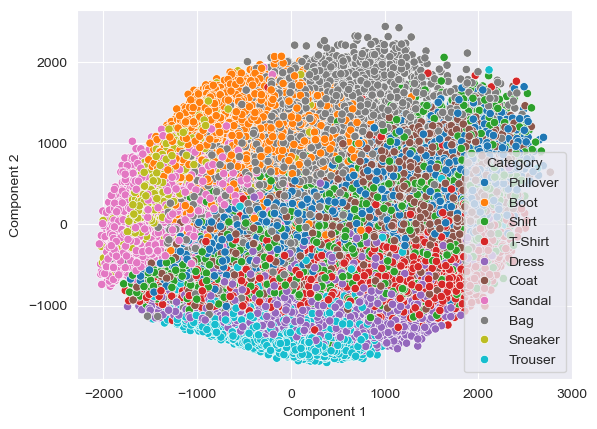

In [63]:
# TODO: Implement
# TODO This does not look like given graph, could this be wrong?
components = pca.fit_transform(fm)
df = pd.DataFrame(components, columns=["Component 1", "Component 2"])
df["Category"] = fm_y
df["Category"] = df["Category"].apply(lambda x: fm_labels[x])
scatterplot(df, x="Component 1", y="Component 2", hue="Category")

## 3.4: ✏️ Reverse PCA
1. Use the inverse transform of a newly created 5-dimensional PCA to obtain the reconstructed image

In [64]:
# TODO: Implement
pca = PCA(n_components=5)
pca.fit_transform(fm)

data_reduced = np.dot(fm, pca.components_.T) # transform
data_original = np.dot(data_reduced, pca.components_) # inverse_transform
df = pd.DataFrame(data_original)

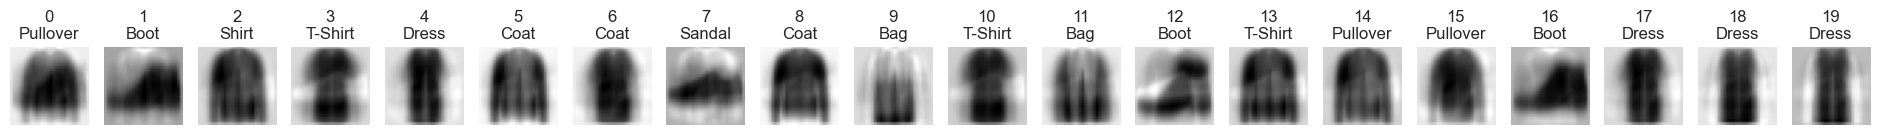

In [65]:
ax = plt.subplots(nrows=1, ncols=num_samples, figsize=(24, 4))[1]
for i in range(num_samples):
    ax[i].set_axis_off()
    ax[i].set_title(f"{i}\n{fm_labels[fm.Category[i]]}")
    temp = df.loc[i].values[1:].reshape((28,28))
    ax[i].imshow(temp, cmap="gray_r")

2. Reshape the reconstructed images to the original shape and visualize them next to the original images

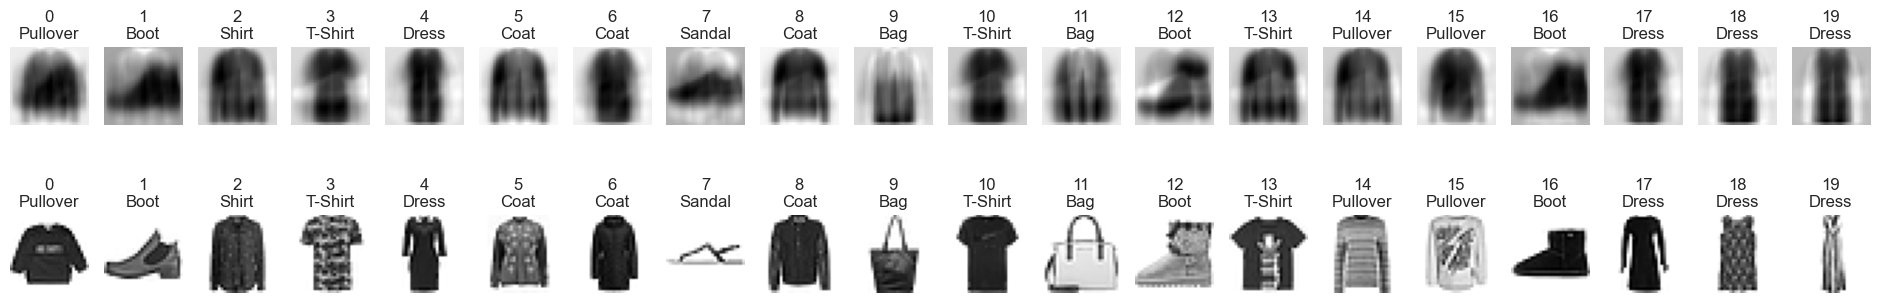

In [66]:
ax = plt.subplots(nrows=2, ncols=num_samples, figsize=(24, 4))[1]
for i in range(num_samples):
    ax[0][i].set_axis_off()
    ax[0][i].set_title(f"{i}\n{fm_labels[fm.Category[i]]}")
    ax[0][i].imshow(df.loc[i].values[1:].reshape((28,28)), cmap="gray_r")
    ax[1][i].set_axis_off()
    ax[1][i].set_title(f"{i}\n{fm_labels[fm.Category[i]]}")
    ax[1][i].imshow(fm.loc[i].values[1:].reshape((28,28)), cmap="gray_r")

plt.show()

3. Redo the last two exercises with various number of components. Which changes do you notice in the resulting image?

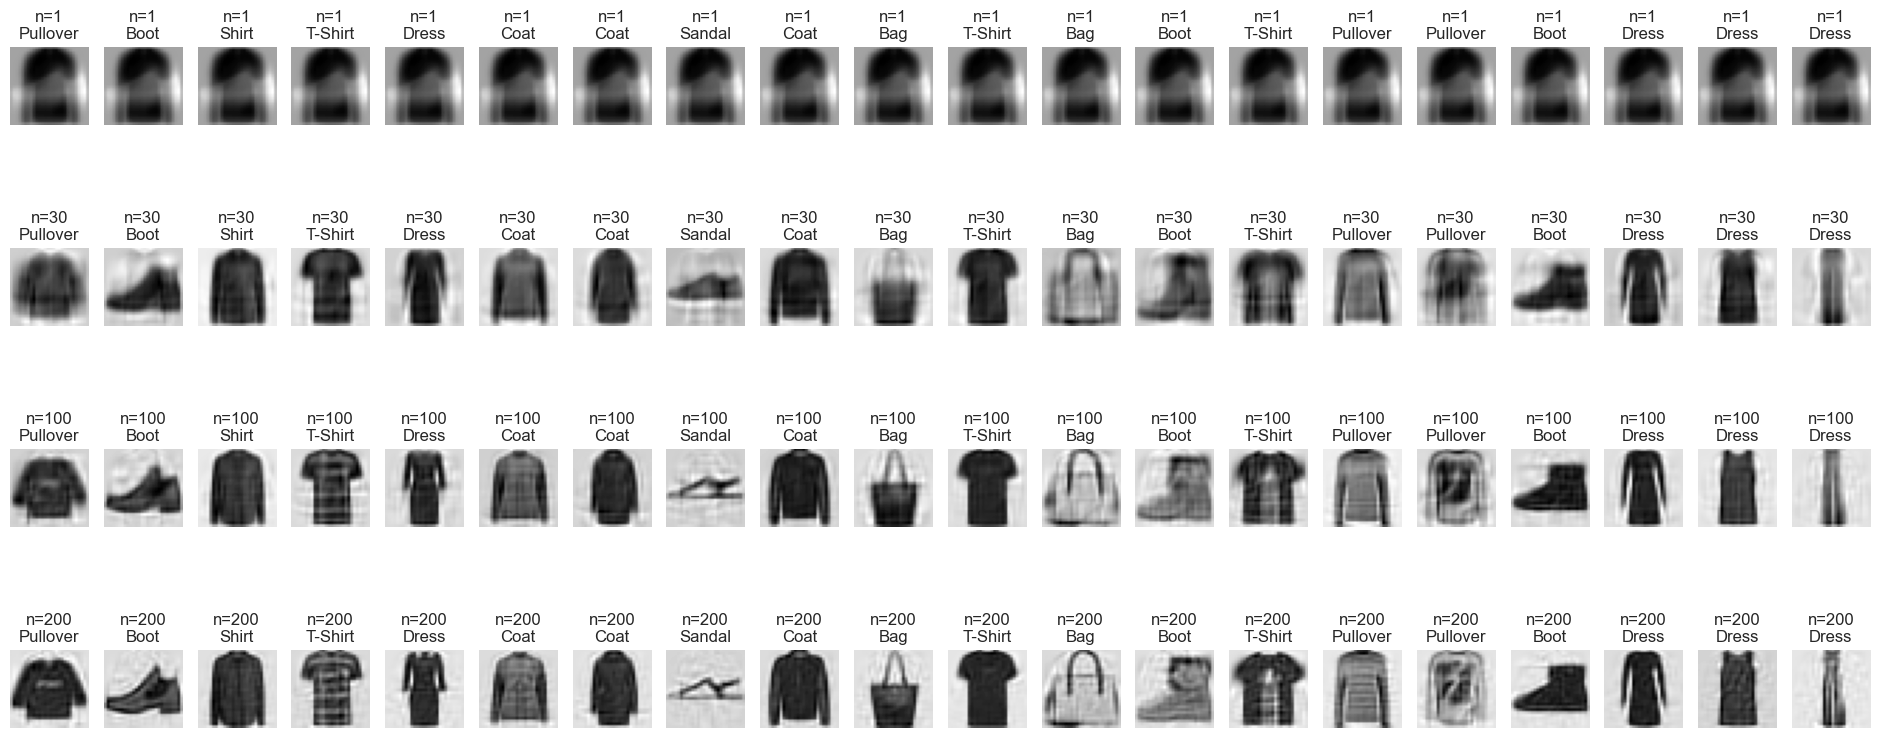

In [67]:
num_comps = [1, 30, 100, 200]
# TODO: Implement and answer
ax = plt.subplots(nrows=len(num_comps), ncols=num_samples, figsize=(24, 10))[1]
for index, num_comp in enumerate(num_comps):
    pca = PCA(n_components=num_comp)
    pca.fit_transform(fm)
    data_reduced = np.dot(fm, pca.components_.T) # transform
    inverse_pca = np.dot(data_reduced, pca.components_) # inverse_transform
    df = pd.DataFrame(inverse_pca)

    for j in range(num_samples):
        ax[index][j].set_axis_off()
        ax[index][j].set_title(f"n={num_comp}\n{fm_labels[fm.Category[j]]}")
        ax[index][j].imshow(df.loc[j].values[1:].reshape((28,28)), cmap="gray_r")

plt.show()